In [21]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Setup duckdb connection
DB_PATH = '../data/db/master.db'
con = duckdb.connect(DB_PATH)

In [23]:
# phhs data is split into 3 tables 
con.sql('show tables;').show()

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ actions │
│ hands   │
│ players │
└─────────┘



In [24]:
# `hands` contains a row of all the scalar fields from each parsed hand
con.sql('select * from hands limit 5;').show()

┌─────────────┬─────────┬─────────┬─────────────┬─────────────┬─────────────────┬────────────────────────┬─────────────┐
│   hand_id   │ variant │ min_bet │ num_players │ num_actions │      venue      │         table          │ is_showdown │
│   varchar   │ varchar │ double  │    int64    │    int64    │     varchar     │        varchar         │   boolean   │
├─────────────┼─────────┼─────────┼─────────────┼─────────────┼─────────────────┼────────────────────────┼─────────────┤
│ 26505473230 │ NT      │    10.0 │           9 │          24 │ Full Tilt Poker │ iO/GshMNibHu9nfu59aQuA │ true        │
│ 26505476108 │ NT      │    10.0 │           5 │          11 │ Full Tilt Poker │ umjybW6fnjsG8VRhxhj6Qg │ false       │
│ 26505476640 │ NT      │    10.0 │           5 │          10 │ Full Tilt Poker │ M7ZIlgnq2NCKlGasybieDQ │ false       │
│ 26505477042 │ NT      │    10.0 │           2 │           3 │ Full Tilt Poker │ 2/LY5VbmKNGw4q2k8STBoQ │ false       │
│ 26505477810 │ NT      │    10.

In [25]:
# `players` contains a row for each player in each hand, containing information specific to each player
con.sql("select * from players where hand_id = '26505473230';").show()

┌─────────────┬────────┬───────────────────┬────────────────────────┬────────────┬────────────────┬────────┬────────────┐
│   hand_id   │  ante  │ blind_or_straddle │          name          │ player_idx │ starting_stack │ payoff │ hole_cards │
│   varchar   │ double │      double       │        varchar         │   int64    │     double     │ double │  varchar   │
├─────────────┼────────┼───────────────────┼────────────────────────┼────────────┼────────────────┼────────┼────────────┤
│ 26505473230 │    0.0 │               5.0 │ XGMcz0rzod8mj+/PpWmQeQ │          1 │          215.0 │  250.0 │ 3c3h       │
│ 26505473230 │    0.0 │              10.0 │ 2ARTzquPkaIcGuXPpecVww │          2 │          274.0 │ -215.0 │ AsAd       │
│ 26505473230 │    0.0 │               0.0 │ J6tpYZsUxsITV+rmbgF7aA │          3 │        1462.75 │    0.0 │ NULL       │
│ 26505473230 │    0.0 │               0.0 │ kEyDGFIR3U/nWU9awogpzw │          4 │          787.0 │    0.0 │ NULL       │
│ 26505473230 │    0.0 │

In [26]:
# Note that this table is not a list of all players.
# Rather, it stores player-specific information for each hand.
# To illustrate this, we can query from this table all the hands that the player `XGMcz0rzod8mj+/PpWmQeQ` participated in:
con.sql("select distinct hand_id from players where name = 'XGMcz0rzod8mj+/PpWmQeQ';")

┌───────────────┐
│    hand_id    │
│    varchar    │
├───────────────┤
│ 27145829146   │
│ 27070071236.0 │
│ 27070415840.0 │
│ 26941401126.0 │
│ 26941513810.0 │
│ 26889615056   │
│ 26890850096   │
│ 26890877294   │
│ 26874634682   │
│ 26395745978   │
│      ·        │
│      ·        │
│      ·        │
│ 26913688656   │
│ 26913898440   │
│ 26913912558   │
│ 26914035970   │
│ 26914069344   │
│ 26914177582   │
│ 26941788398   │
│ 26941980760   │
│ 26942091582   │
│ 26505345892   │
├───────────────┤
│   3054 rows   │
│  (20 shown)   │
└───────────────┘

In [27]:
# `actions` contains a row for each action in each hand
con.sql("select * from actions where hand_id = '26941575934';").show()

┌─────────────┬──────────────┬─────────┬─────────────┬────────┬──────────────────┬─────────────┬─────────┬──────────────┐
│   hand_id   │ action_index │  actor  │ action_type │ amount │ total_pot_amount │ is_terminal │  cards  │  raw_action  │
│   varchar   │    int64     │ varchar │   varchar   │ double │      double      │   boolean   │ varchar │   varchar    │
├─────────────┼──────────────┼─────────┼─────────────┼────────┼──────────────────┼─────────────┼─────────┼──────────────┤
│ 26941575934 │            1 │ d       │ dh          │   NULL │             15.0 │ false       │ p1 ???? │ d dh p1 ???? │
│ 26941575934 │            2 │ d       │ dh          │   NULL │             15.0 │ false       │ p2 ???? │ d dh p2 ???? │
│ 26941575934 │            3 │ d       │ dh          │   NULL │             15.0 │ false       │ p3 ???? │ d dh p3 ???? │
│ 26941575934 │            4 │ d       │ dh          │   NULL │             15.0 │ false       │ p4 ???? │ d dh p4 ???? │
│ 26941575934 │         

In [28]:
# Okay, enough with the basics. Let's answer some questions.
# Q1: Who are the most active players on the site?

query = '''
select
    p.name,
    count(*) as cnt
from players p join hands h on p.hand_id = h.hand_id
group by p.name
order by cnt desc
limit 5;
'''

con.sql(query).show()

┌────────────────────────┬───────┐
│          name          │  cnt  │
│        varchar         │ int64 │
├────────────────────────┼───────┤
│ SKPTemuzsQCg9dvPijYBag │ 36383 │
│ vLGM5sqz/S5lzoWbnKGyZw │ 33960 │
│ CMAB5zPvKjJHdECgp5JG/A │ 24490 │
│ 0gGhmq4EflzwP0m6xuKCWA │ 22473 │
│ p3+GqqGEudkcZNlg2g402A │ 22470 │
└────────────────────────┴───────┘



In [29]:
# Q2: What does the distribution of hand lengths look like?

query = '''
select
    num_actions,
    count(*) as cnt
from hands
group by num_actions
'''

num_actions_df = con.sql(query).df()
num_actions_df.head()

,num_actions,cnt
0,2,6
1,3,67005
2,4,76700
3,5,25053
4,6,11003


<Axes: xlabel='num_actions', ylabel='cnt'>

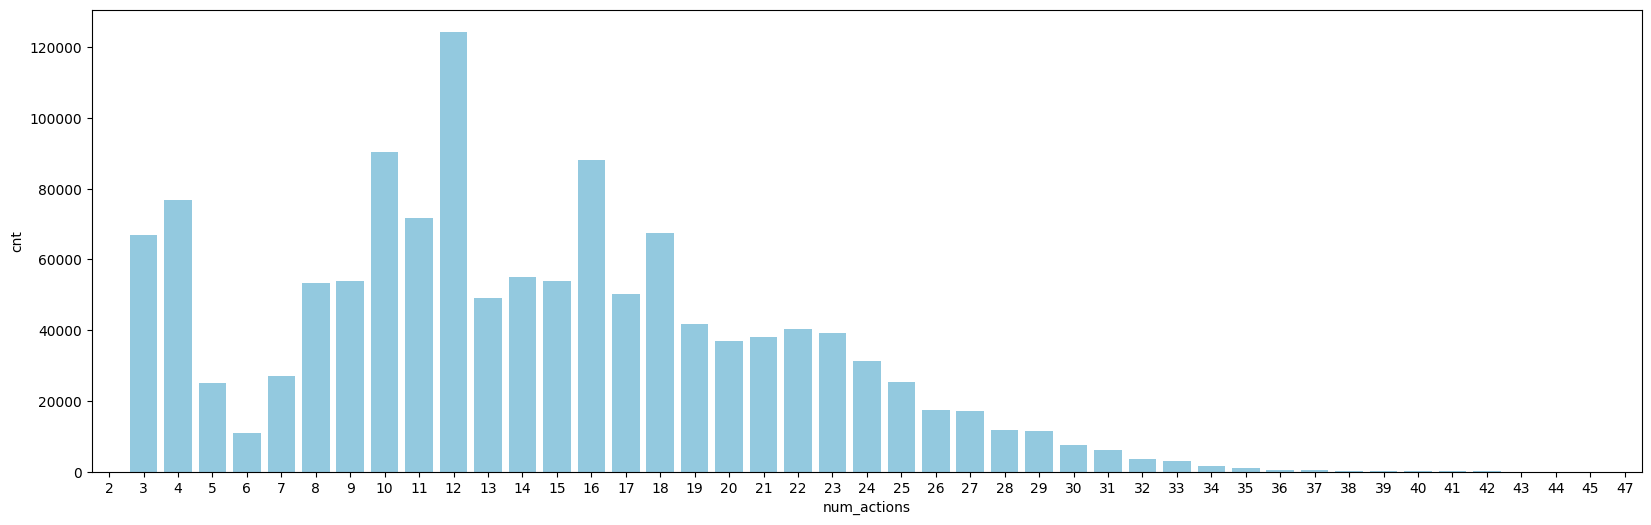

In [30]:
plt.figure(figsize=(20,6))
sns.barplot(x='num_actions', y='cnt', data=num_actions_df, color='skyblue')

In [31]:
# Q3: What does the distribution of VPIP's look like?

query = '''
with flop_index as (
    select hand_id, min(action_index) as flop_action_index
    from actions
    where action_type = 'db' and length(cards) = 6
    group by hand_id
),

preflop_actions as (
    select
        a.hand_id,
        p.name as player_name,
        coalesce(a.amount, 0) as amount,
        coalesce(p.blind_or_straddle, 0) as blind_or_straddle
    from actions a
    join players p
      on a.hand_id = p.hand_id and a.actor = 'p' || cast(p.player_idx as varchar)
    left join flop_index f
      on a.hand_id = f.hand_id
    where a.action_index < coalesce(f.flop_action_index, -1)
),

vpip as (
    select
        hand_id,
        player_name,
        case when sum(case when amount > blind_or_straddle then 1 else 0 end) > 0
             then 1 else 0 end as vpip
    from preflop_actions
    group by hand_id, player_name
)

select
    player_name,
    avg(coalesce(vpip, 0)) as vpip,
    count(distinct hand_id) as sample_size
from vpip
group by player_name
having sample_size >= 200
order by random();
'''

df_vpip = con.sql(query).df()
df_vpip.head()

,player_name,vpip,sample_size
0,3M9//fqe64U5Ir4B975DXw,0.192867,757
1,6RrPEAZ0DH7ZxGcxFEjj0w,0.123333,300
2,iPle4a50EFP4tNFx+ICPtw,0.095238,441
3,OfeQbhhBvVH1xTD1lVB5sQ,0.193966,232
4,xx7xZjCsEeXKOt/Kxb7kBA,0.130282,284


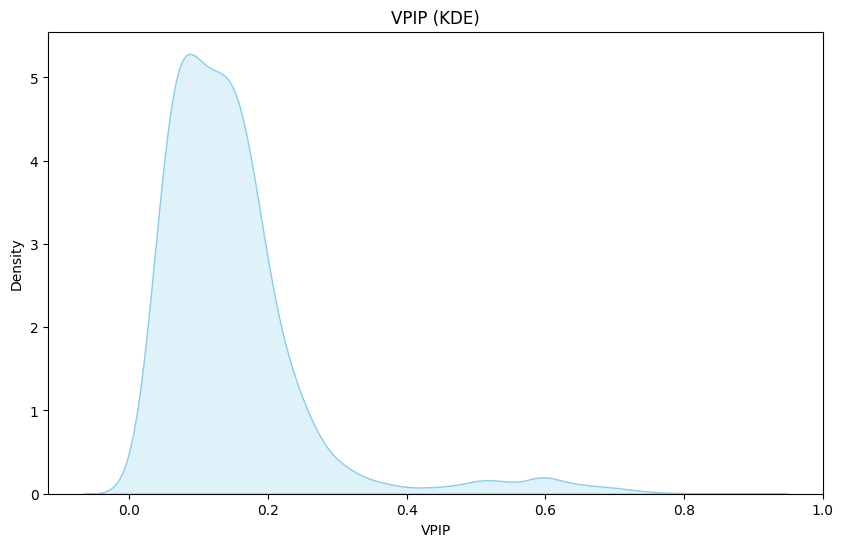

In [32]:
plt.figure(figsize=(10,6))
sns.kdeplot(df_vpip['vpip'], fill=True, color='skyblue')
plt.title('VPIP (KDE)')
plt.xlabel('VPIP')
plt.ylabel('Density')
plt.show()

In [33]:
con.close()